<a href="https://colab.research.google.com/github/H93JEBALI/Stock-Crypto-prediction/blob/main/Price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real time collect of BTC price Data from Yahoo Finance API
The goal of the section is only to visualize the price of BTC-USD over a history of days. The data is collected from the Yahoo Finance API.

This data will not be further used in the analysis.

In [ ]:
# Import Packages
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objs as go

In [ ]:
btc = yf.Ticker('BTC-USD')

# get stock info
print(btc.info)

# get historical market data
hist_btc = btc.history(period="3y",  interval = '1d')

In [ ]:
# add a day column to the dataframe
hist_btc.reset_index(drop = False, inplace = True)
hist_btc['Day'] = hist_btc['Date']
hist_btc.set_index('Date', inplace = True)

In [ ]:
#declare figure
fig = go.Figure()

#Candlestick
fig.add_trace(go.Candlestick(x=hist_btc.index,
                open=hist_btc['Open'],
                high=hist_btc['High'],
                low=hist_btc['Low'],
                close=hist_btc['Close'],
                name = 'market data'))

# Add titles
fig.update_layout(
    title='Bitcoin live share price evolution',
    yaxis_title='Bitcoin Price (kUS Dollars)')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label="7d", step="day", stepmode="backward"),
            dict(count=1, label="1M", step="month", stepmode="backward"),
            dict(count=6, label="6M", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# add Halving date to see its impact on BTC price.
fig.update_layout(
    title='Halving',
    yaxis_title= 'Bitcoin Price (US Dollars)',
    shapes = [dict(
        x0='2020-05-11', x1='2020-05-11', y0=0, y1=1, xref='x', yref='paper',
        line_width=2)],
    annotations=[dict(
        x='2020-05-11', y=0.05, xref='x', yref='paper',
        showarrow=False, xanchor='left', text='BTC halving')]
)

#Show
fig.show()

# **Train a prediction model using LSTMs and a historical data exported from coinbase exchange**

The data used to train our model was extracted from a coinbase API and stating the price of BTC in USD.

In [ ]:
# Load data
df_c = pd.read_csv('coinbaseUSD.csv')
df_c.head()

In [ ]:
import matplotlib.pyplot as plt

# PLOTS
fig = plt.figure(figsize=[9, 5])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.plot(df_c.Weighted_Price, '-', label='By Days')
plt.legend()

# plt.tight_layout()
plt.show()

In [ ]:
# add date* column and aggregate by it to calculate the BTC weighted price per day
# Real_Price is the series of prices that we will used to train our model

df_c['date'] = pd.to_datetime(df_c['Timestamp'],unit='s').dt.date
group = df_c.groupby('date')
Real_Price = group['Weighted_Price'].mean()

In [ ]:
# Here we start data preparation for the training part. A first step is to split data onto train and validation chuncks.
# Train data : give the model a statistical patterns about the BTC price movement idealy over a long period of time

prediction_days = 365 #number of days to validate the training on
df_train= Real_Price[len(Real_Price)-prediction_days:]
df_test= Real_Price[:len(Real_Price)-prediction_days]

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# Second step of data prep is to reshape the train (or the validation set eventially) to fit the chosen model input shape.
# In our case, we chose to go for an LSTM model that requests its input to be under (len(training_set), 1) shape ((len(df_test), 1) eventially)
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

# Third step of data prep is to scale the data to eliminate the biais data points values can add to the models training.
# MinMaxScaler scaler seems a good choice for our data and it preserves the shape of the original distribution.
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)


n_future = 1       # number of days to predict
n_past = 30        # number of days to use to predict
X_train = []
y_train = []


# the LSTM model input shape preparation. 
# X_train takes the n_past* number of days BTC prices ( used to predict )
# y_train takes the n_past+1* day of BTC price (to be predicted)
for i in range(n_past, len(training_set) - n_future + 1) :
  X_train.append(training_set[i - n_past:i, 0:len(training_set)])
  y_train.append(training_set[i + n_future -1:i + n_future, 0])


X_train, y_train = np.array(X_train), np.array(y_train)
print('trainX shape == {}.'.format(X_train.shape))
print('trainY shape == {}.'.format(y_train.shape))

trainX shape == (335, 30, 1).
trainY shape == (335, 1).


Epoch 1/50
38/38 [==============================] - 2s 17ms/step - loss: 0.0219 - val_loss: 0.0605
Epoch 2/50
38/38 [==============================] - 0s 11ms/step - loss: 0.0139 - val_loss: 0.0572
Epoch 3/50
38/38 [==============================] - 0s 11ms/step - loss: 0.0121 - val_loss: 0.0759
Epoch 4/50
38/38 [==============================] - 0s 11ms/step - loss: 0.0107 - val_loss: 0.0589
Epoch 5/50
38/38 [==============================] - 0s 12ms/step - loss: 0.0098 - val_loss: 0.0446
Epoch 6/50
38/38 [==============================] - 0s 12ms/step - loss: 0.0084 - val_loss: 0.0431
Epoch 7/50
38/38 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0483
Epoch 8/50
38/38 [==============================] - 0s 12ms/step - loss: 0.0069 - val_loss: 0.0161
Epoch 9/50
38/38 [==============================] - 0s 12ms/step - loss: 0.0058 - val_loss: 0.0169
Epoch 10/50
38/38 [==============================] - 0s 12ms/step - loss: 0.0050 - val_loss: 0.0318
Epoch 11/

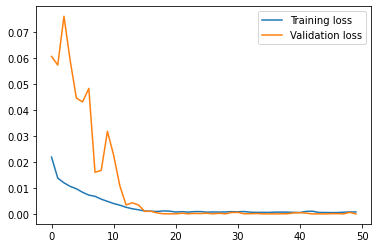

In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer 
regressor.add(LSTM(units = 50, activation = 'sigmoid', input_shape = (None, 1)))   #relu

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

#regressor.summary()

# Fitting the RNN to the Training set
hist = regressor.fit(X_train, y_train, batch_size = 8, epochs = 50, validation_split=0.1, verbose=1)

plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
# Use the trained LSTM model to predict the next n_days_for_prediction days counting from the last day of our training set.
n_past = 90                # number of days used to predict
n_days_for_prediction= 14  # number of days to predict

# add date column
train_dates = pd.to_datetime(df_c['date'])
 
# create the n_days_for_prediction days to be predicted list ( for visualisation purposes )
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq='1d').tolist()
print(predict_period_dates)

In [ ]:
#Make prediction
prediction = regressor.predict(X_train[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
y_pred_future = sc.inverse_transform(prediction)[:,0]

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'Weighted_Price':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



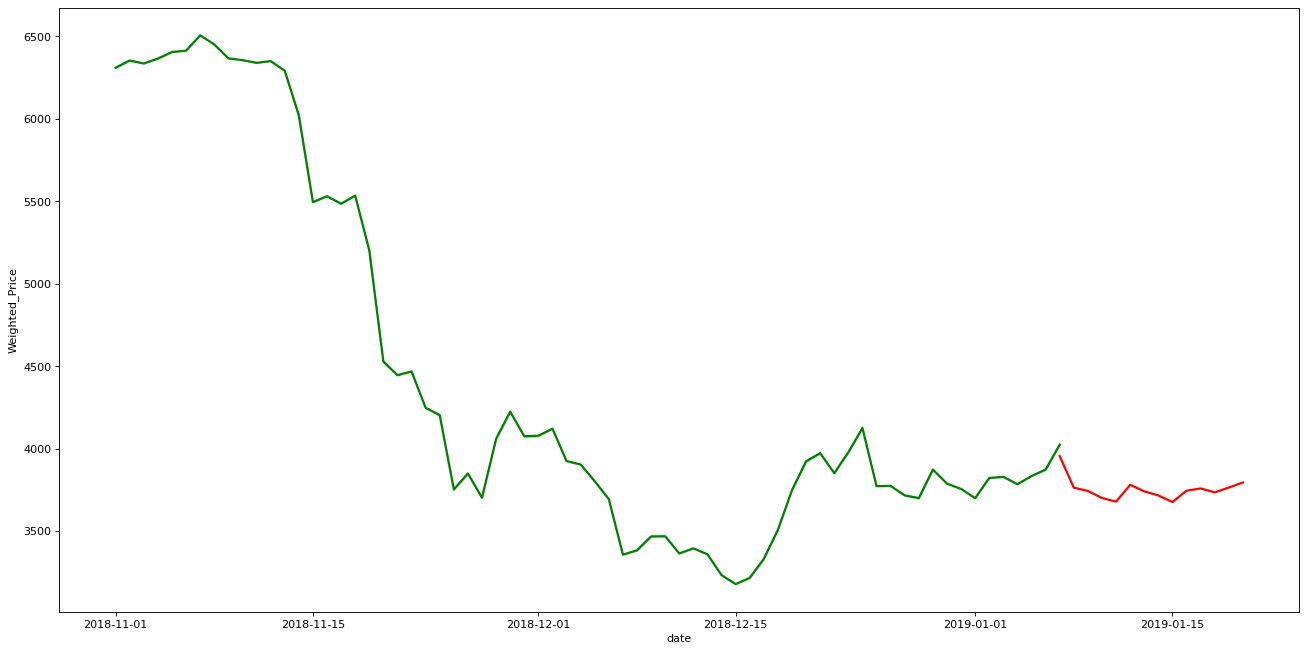

In [ ]:
import seaborn as sns

# Visualize the result of prediction
plt.figure(figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  


original = df_c[['date', 'Weighted_Price']]
original['date']=pd.to_datetime(original['date'])
original = original[original['date'] >= '2018-11-01']

sns.lineplot(x = original['date'], y = original['Weighted_Price'], color = 'green', linewidth = 2);
sns.lineplot(x = df_forecast['date'], y = df_forecast['Weighted_Price'], color = 'red', linewidth = 2);

# **Predict BTC price using the Yahoo Finance history for the last 60 days**

On this section, we try to apply the trained model on newer set of BTC-USD data ( from 2021).

In [ ]:
hist_btc_prd = hist_btc[hist_btc['Day'] >= '2021-05-01']   # Data collected from Yahoo API
hist_btc_prd.head(5)

In [ ]:
hist_btc_prd[['Day', 'Close']].head(10)

In [ ]:
n_past = 50
n_days_for_prediction= 60 #let us predict past 7 days

# create the n_days_for_prediction days to be predicted list ( for visualisation purposes )
pred_dates = pd.to_datetime(hist_btc_prd['Day'])
predict_period_dates = pd.date_range(list(pred_dates)[-n_past], periods=n_days_for_prediction, freq='1d').tolist()
print(predict_period_dates)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



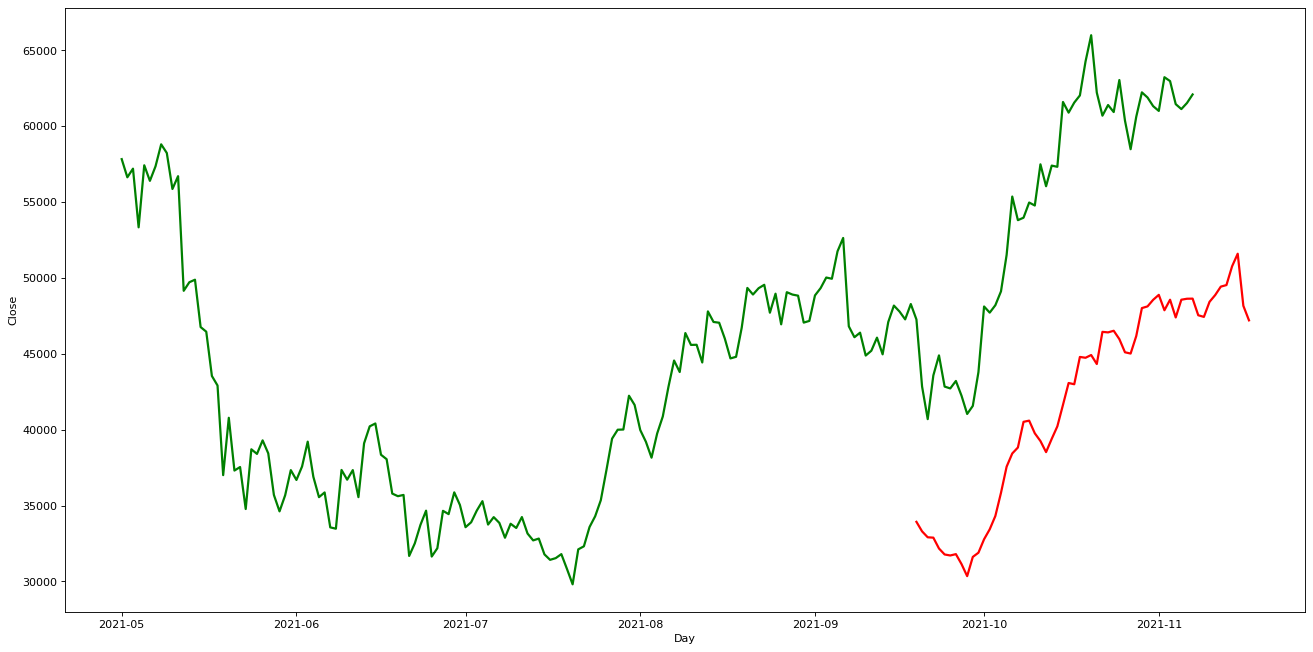

In [ ]:
pred_set = hist_btc_prd['Close'].values
pred_set = np.reshape(pred_set, (len(pred_set), 1))

sc = MinMaxScaler()
pred_set = sc.fit_transform(pred_set)

n_future = 60
n_past = 50
X_pred = []

for i in range(n_past, len(pred_set) - n_future + 1) :
  X_pred.append(pred_set[i - n_past:i, 0:len(pred_set)])
X_pred = np.array(X_pred)


#Make prediction
prediction = regressor.predict(X_pred[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
y_pred_future = sc.inverse_transform(prediction)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Day':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Day']=pd.to_datetime(df_forecast['Day'])

plt.figure(figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  


original = hist_btc_prd[['Day', 'Close']]
original['Day']=pd.to_datetime(original['Day'])
#original = original[original['date'] >= '2018-11-01']

sns.lineplot(x = original['Day'], y = original['Close'], color = 'green', linewidth = 2)
sns.lineplot(x = df_forecast['Day'], y = df_forecast['Close'], color = 'red', linewidth = 2)